<a href="https://colab.research.google.com/github/teng-yu-an/Bank-Customer-Churn-with-XAI/blob/main/Bank_Customers_Churn_with_Shap_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 可解釋機器模型 Explainable AI<br>

機器學習方法中許多演算法的計算方式較複雜，加上實務上我們要做決策時，常需要了解模型為何做出這樣的決策。

以此筆銀行帳戶流失資料為例，當我們由機器學習模型預測出哪些顧客會流失、哪些不會時，會想要知道模型判斷他是流失顧客的重要因素為何。

而可解釋機器模型 Explainable AI 即可幫我們解決此問題。目前主要使用有以下四種方法：
- LIME
- SHAP
- LRP(Layer-wise relevance propagation)
- Counterfactual Explaination
<br>

Abstract:<br>
客戶由於一些損失和其他問題而從銀行撤回帳戶，藉由數據分析、機器學習模型及XAI，幫助我們了解客戶撤回銀行帳戶的原因。<br>

資料：<br>
[Churn Modeling.csv](https://github.com/teng-yu-an/Bank-Customer-Churn-with-XAI/blob/main/Churn%20Modeling.csv)<br>
```資料來源：https://www.kaggle.com/datasets/santoshd3/bank-customers```


In [2]:
!pip install shap
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=31fe4b04f1445e998dfe67d3d2ffa5e11af427e76ba5189c84acc70746183417
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget

In [6]:
wget.download('https://raw.githubusercontent.com/teng-yu-an/Bank-Customer-Churn-with-XAI/main/Churn_Modeling.csv')


'Churn_Modeling.csv'

In [8]:
data = pd.read_csv('Churn_Modeling.csv')

In [9]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### EDA

In [10]:
data.Exited.value_counts()
# 一萬筆資料中，流失的顧客有2037位，佔20.4%

0    7963
1    2037
Name: Exited, dtype: int64

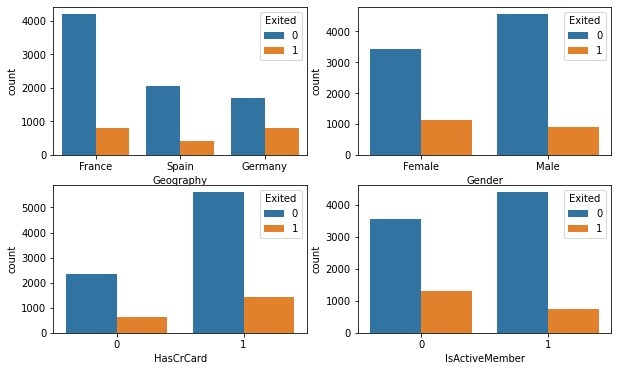

In [11]:
# 類別變數直方圖

fig, axar = plt.subplots(2, 2, figsize=(10,6))
sns.countplot(x='Geography', hue='Exited', data=data, ax=axar[0][0])
sns.countplot(x='Gender', hue='Exited', data=data, ax=axar[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=data, ax=axar[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=data, ax=axar[1][1])
plt.show()
# 法國顧客最多，流失率相較西班牙及德國顧客也較低
# 女性顧客流失率相較男性顧客高
# 擁有信用卡的人較多
# 雖沒有銀行帳戶，但仍和銀行有債券、保險往來的顧客，在流失銀行帳戶的比例比較高

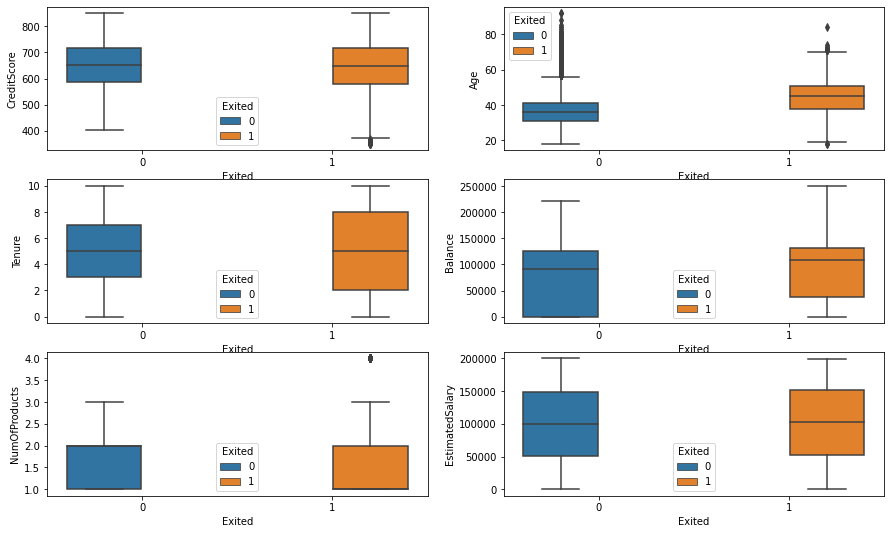

In [12]:
# 連續變數盒型圖

fig, axar = plt.subplots(3, 2, figsize=(15,9))
sns.boxplot(x='Exited', y='CreditScore', hue='Exited', data=data, ax=axar[0][0])
sns.boxplot(x='Exited', y='Age', hue='Exited', data=data, ax=axar[0][1])
sns.boxplot(x='Exited', y='Tenure', hue='Exited', data=data, ax=axar[1][0])
sns.boxplot(x='Exited', y='Balance', hue='Exited', data=data, ax=axar[1][1])
sns.boxplot(x='Exited', y='NumOfProducts', hue='Exited', data=data, ax=axar[2][0])
sns.boxplot(x='Exited', y='EstimatedSalary', hue='Exited', data=data, ax=axar[2][1])
plt.show()
# 流失的顧客和保留的顧客在信用分數上沒有什麼差異
# 流失的顧客年齡較保留的顧客高
# 有極端任期的顧客較易流失
# 流失的顧客中銀行帳戶餘額較多
# 流失與否在商品數及薪水上無顯著差異

### Feature Engineering

In [13]:
modelData = data.drop(columns = ['RowNumber','Surname', 'CustomerId'])

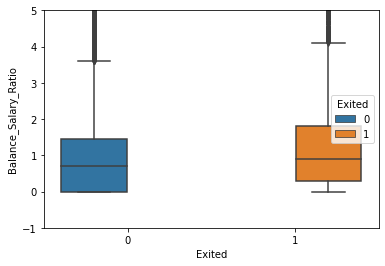

In [14]:
# 新增變數為「銀行帳戶餘額跟薪水的比例」

modelData['Balance_Salary_Ratio'] = modelData['Balance']/modelData['EstimatedSalary']
sns.boxplot(x='Exited', y='Balance_Salary_Ratio', hue='Exited', data=modelData)
plt.ylim(-1,5)
plt.show()
# 流失顧客存款和薪水比值較高

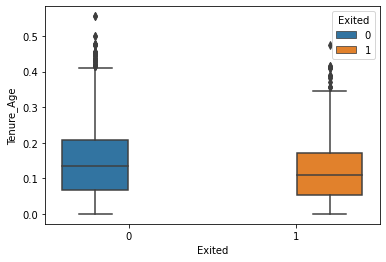

In [15]:
# 新增變數為「任期除以年齡」

modelData['Tenure_Age'] = modelData.Tenure/(modelData.Age)
sns.boxplot(x='Exited', y='Tenure_Age', hue='Exited', data=modelData)
plt.show()

In [16]:
# 新增變數為「信用分數除以年齡」

modelData['CreditScore_Age'] = modelData.CreditScore/(modelData.Age)

In [17]:
modelData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CreditScore           10000 non-null  int64  
 1   Geography             10000 non-null  object 
 2   Gender                10000 non-null  object 
 3   Age                   10000 non-null  int64  
 4   Tenure                10000 non-null  int64  
 5   Balance               10000 non-null  float64
 6   NumOfProducts         10000 non-null  int64  
 7   HasCrCard             10000 non-null  int64  
 8   IsActiveMember        10000 non-null  int64  
 9   EstimatedSalary       10000 non-null  float64
 10  Exited                10000 non-null  int64  
 11  Balance_Salary_Ratio  10000 non-null  float64
 12  Tenure_Age            10000 non-null  float64
 13  CreditScore_Age       10000 non-null  float64
dtypes: float64(5), int64(7), object(2)
memory usage: 1.1+ MB


### Model Fitting

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [19]:
modelData.loc[modelData['HasCrCard'] == 0,'HasCrCard'] = -1
modelData.loc[modelData['IsActiveMember'] == 0,'IsActiveMember'] = -1

modelData = pd.get_dummies(modelData, columns=['Geography', 'Gender'])

In [20]:
X = modelData.drop(['Exited'], axis=1)
y = modelData.Exited

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### Model 1: Random Forest 

In [21]:
rfModel = RandomForestClassifier(max_features='log2', n_estimators=80)
classifier = rfModel.fit(np.array(X_train), np.array(y_train))
predicted = rfModel.predict(X_test)

print(classification_report(np.array(y_test), predicted))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.74      0.50      0.60       405

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


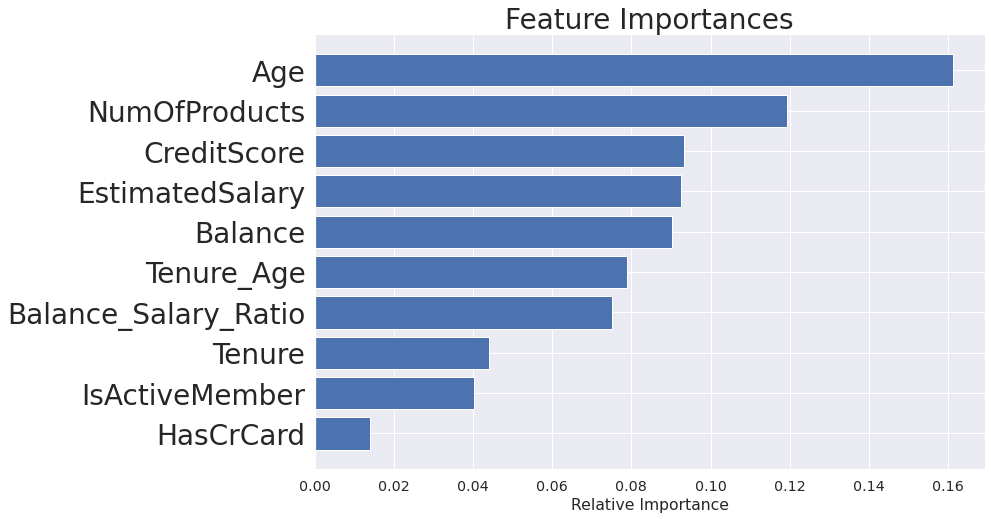

In [22]:
# 特徵重要度
sns.set(style='darkgrid', font='SimHei', rc={'figure.figsize':(12, 8)}, font_scale=1.3)# 設定讓圖顯示中文

topn = 10
importances = rfModel.feature_importances_[:topn]
indices = np.argsort(importances)[:topn]
features = X_train.columns[:topn]
plt.title('Feature Importances', fontsize=28)
plt.barh(range(len(indices[:topn])), importances[indices], color='b', align='center')
plt.yticks(range(len(indices[:topn])), [features[i] for i in indices], fontsize=28)
plt.xlabel('Relative Importance')
plt.show()

由上圖可知，前十名重要變數有以下：

年齡、商品數量、信用分數、帳戶餘額、薪資、任期除以年齡、餘額占薪水的比例、任期、是否與銀行還有往來、是否有信用卡

##### Model 1: XGBoost

In [24]:
# 建立XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3)
# 使用訓練資料訓練模型
classifier = xgboostModel.fit(np.array(X_train), np.array(y_train))
# 使用訓練資料預測分類
predicted = xgboostModel.predict(np.array(X_test))

print(classification_report(np.array(y_test), predicted))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.73      0.53      0.61       405

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.76      2000
weighted avg       0.86      0.86      0.86      2000



為理解影響XGBoost 模型預測的決策因素，這裡使用可解釋機器模型的套件：**SHAP**

可以計算每個特徵的shap value，來衡量該特徵對預測的貢獻度。

- 點的顏色: Feature value 的大小，越紅越高、越藍越低；
- X 軸： shape value 的範圍

In [25]:
import shap

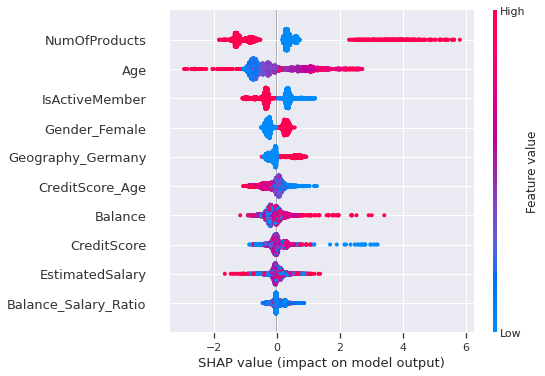

In [26]:
# Summary Plot 對整體資料解釋

explainer = shap.Explainer(classifier)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, max_display = 10) #max_display 設定顯示前幾重要的特徵

由上圖可以看出重要特徵的影響有以下特徵：
- 購買的商品數量(NumOfProducts)、年齡(Age)越極端的多或極端的少，都會對模型很有貢獻度。
- 沒有和銀行有往來的顧客(IsActiveMember)越傾向預測為流失客戶。
- 信用分數跟年齡比值(CreditScore_Age)越低，越傾向預測為流失客戶。
- 女性較易為流失客戶。

購買的商品數量、年齡、是否銀行有往來是隨機森林跟XGBoost 都顯示重要的變數。

我們還可以利用SHAP 進一步看個別客戶被模型預測為流失或非流失的原因。

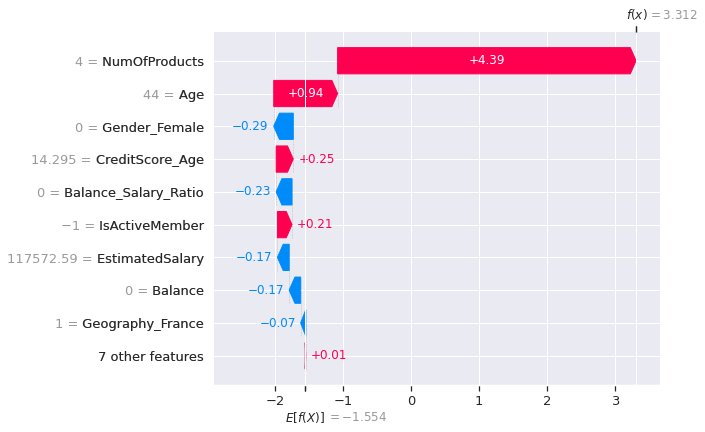

In [28]:
# waterfall 對單一資料解釋

idx = np.where(classifier.predict(np.array(X_train)) == 1)[0] # 被預測為1（流失）的index
shap.plots.waterfall(shap_values[idx[0]])

In [29]:
np.array(y_train)[idx[0]] # 實際上此筆資料也是流失顧客

1

上圖為模型預測為流失顧客的第一位顧客，紅色代表正的貢獻度、藍色代表負的貢獻度
- 正面的影響：
  - Age: 是54歲的顧客
  - CreditScore_Age: 信用分數跟年齡比值為13.148，低於平均比值17.9
  - Balance_Salary_Ratio: 銀行帳戶餘額跟薪水的比例為1.025，高於中位數的0.74，但仍使模型傾向預測為流失顧客
  - EstimatedSalary: 薪水高於整體資料的Q3，影響預測為流失顧客
- 負面的影響：
  - IsActiveMember: 此位顧客仍是往來客戶，使模型預測降低流失機率
  - Gender_Female: 此顧客為女性，使模型預測降低流失機率

In [30]:
retain_customer = np.where(np.array(y_train)[idx] == 0)[0] # 非流失顧客的index
np.array(y_train)[retain_customer[0]] # 實際上此筆資料非流失顧客

0

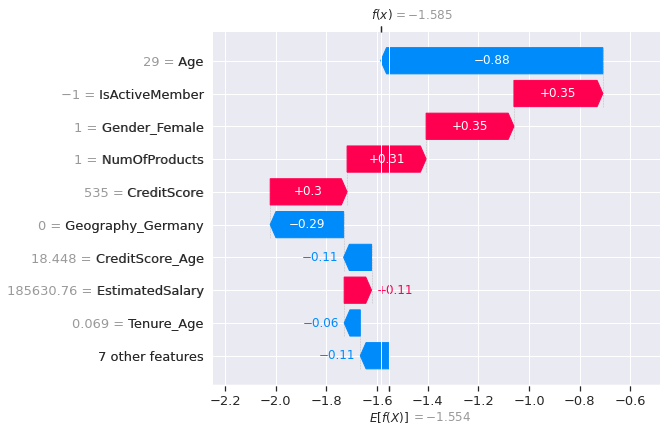

In [31]:
shap.plots.waterfall(shap_values[retain_customer[0]])

上圖為模型預測為非流失顧客的個別特徵影響